<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>DRAFT: Coadd Recreation</b> <br>
Contact author(s): Melissa Graham <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: intermediate <br>

In [1]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** Recreate a Coadded image from a subset of the input calexps.

**Skills:** Use of pipetasks for image coaddition. Creating and writing to Butler collections. Properties of deepCoadds.

**LSST Data Products:** deepCoadd, calexp

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:** Originally developed by Melissa Graham and **add names who helped**.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-1.lsst.io">dp0-1.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook shows how to retrieve information about the individual images that contributed to a deepCoadd, and how to make a new Coadded image using only a subset of the inputs.

In the past you might have used iraf's imcombine, or Astromatics's SWarp, to coadd images.
This notebook demonstrates the appropriate methods for coadding LSST images with the LSST Science Pipelines.

Science applications of coadding a subsets of LSST images includes searching for faint, slowly-evolving transients or variables (e.g.,, coadding images by season), using the effects of differential chromatic refraction (e.g., coadding images in bins of airmass), or perhaps searching for low surface brightness features (e.g., coadding only dark-time images with the faintest sky backgrounds).

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_Use code cell comments to describe the packages being imported._

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import pandas
pandas.set_option('display.max_rows', 1000)

import lsst.daf.butler as dafButler

import lsst.geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from astropy.time import Time

### 1.2 Set Up

In [3]:
repo = 'dp02'
# collection = '2.2i/runs/DP0.2/v23_0_1_rc1/PREOPS-905/pilot_tract4431'
collection = '2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step_all'

Known issue: it is OK to ignore a pink-window message saying "WARNING: version mismatch between CFITSIO header (v4.000999999999999) and linked library (v4.01)."

In [4]:
butler = dafButler.Butler(repo, collections=collection)

## 2. Identify the calexps to combine

### 2.1. Start with a deepCoadd

Choose the deepCoadd that contains the coordinates of a known galaxy cluster.
These are the same coordinates we use in the introductory notebook.

In [5]:
ra_deg = 55.745834
dec_deg = -32.269167

my_spherePoint = lsst.geom.SpherePoint(ra_deg*lsst.geom.degrees,
                                       dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)

dataId = {'band': 'i', 'tract': my_tract.tract_id, 
          'patch': my_patch.getSequentialIndex()}
deepCoadd = butler.get('deepCoadd', dataId=dataId)

Uncomment the following cell to show the deepCoadd image.

In [6]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(deepCoadd.image)
# plt.gca().axis('off')

It is not necessary to know the bounding box for a deepCoadd in order to find all of the calexps that were used to assemble it.
But, if you want to learn more about the deepCoadd metadata, uncomment and execute the following cells.

The deepCoadd's bounding box, corners, and WCS.

In [7]:
# deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=dataId)
# print( deepCoadd_bbox.beginX, deepCoadd_bbox.beginY, 
#       deepCoadd_bbox.endX, deepCoadd_bbox.endY )

# print( deepCoadd_bbox.getCorners() )

# deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=dataId)
# print( deepCoadd_wcs )

# del deepCoadd_bbox, deepCoadd_wcs

### 2.2. Retrieve deepCoadd inputs

In [8]:
%%time
coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)

CPU times: user 1.9 s, sys: 855 ms, total: 2.76 s
Wall time: 2.69 s


In [9]:
coadd_inputs_ccds_table = coadd_inputs.ccds.asAstropy()

Uncomment the following cell to view the table.

In [10]:
# coadd_inputs_ccds_table
len(coadd_inputs_ccds_table)

571

In [11]:
all_visits = np.asarray(coadd_inputs_ccds_table['visit'], dtype='int')
all_ccds = np.asarray(coadd_inputs_ccds_table['ccd'], dtype='int')

### 2.3. Get metadata for the input calexps

**THIS IS SLOW, SEE TO DO LIST FOR OPTIONS**

It is faster to only retrieve metadata from the calexp metadata for unique visits (since all ccds of a given visit will have the same MJD). 
The cell below takes four minutes, so we have saved the results to a file.

Retrieve metadata of observation date and airmass for this example.
This notebook will only use observation date to identify a subset to coadd.
Using a user-specified airmass range will be left as an exercise for the learner.

We do not need to retrieve the filter for these visits, because we specified i-band for the deepCoadd, and these are only the visits that contributed to that deepCoadd -- so they are all i-band, too.

In [12]:
# %%time

# unique_visits = np.unique(all_visits)
# print(len(unique_visits))

# unique_visits_mjds = np.zeros( len(unique_visits), dtype='float' )
# unique_visits_airmass = np.zeros( len(unique_visits), dtype='float' )
# for i in range(len(unique_visits)):
#     calexp_md = butler.get('calexp.metadata', detector=1, visit=unique_visits[i])
#     unique_visits_mjds[i] = Time(calexp_md['DATE-END'], format='isot', scale='utc').mjd
#     unique_visits_airmass[i] = calexp_md['AIRMASS']
#     del calexp_md

# fout = open('data/coadd_inputs_metadata.txt', 'w')
# for i in range(len(unique_visits)):
#     fout.write('%10i %10.4f %5.3f \n' % (unique_visits[i], 
#                                          unique_visits_mjds[i], 
#                                          unique_visits_airmass[i]))
# fout.close()

In [13]:
unique_visits = np.loadtxt('data/coadd_inputs_metadata.txt', dtype='int', usecols=(0))
unique_visits_mjds = np.loadtxt('data/coadd_inputs_metadata.txt', dtype='float', usecols=(1))
unique_visits_airmass = np.loadtxt('data/coadd_inputs_metadata.txt', dtype='float', usecols=(2))

all_mjds = np.zeros(len(all_visits), dtype='float')
all_airmass = np.zeros(len(all_visits), dtype='float')
for i in range(len(all_visits)):
    tx = np.where( all_visits[i] == unique_visits )[0]
    try:
        len(tx) == 1
    except:
        print('error, no match for a visit to a unique visit')
    else:
        all_mjds[i] = unique_visits_mjds[tx]
        all_airmass[i] = unique_visits_airmass[tx]

del unique_visits, unique_visits_mjds, unique_visits_airmass

Show how observations for this deepCoadd were acquired over time, and identify a date range.

In the plot we call this the "season of interest", but it could be a shorter or longer time-frame.

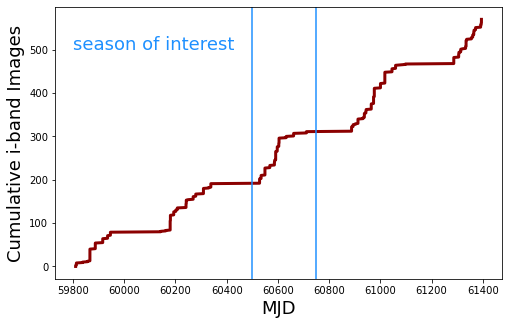

In [14]:
fig = plt.figure(figsize=(8,5))

sort_all_mjds = np.sort(all_mjds)
yaxis = np.arange( len(all_mjds), dtype='int')

plt.plot( sort_all_mjds, yaxis, ls='solid', lw=3, color='darkred' )

plt.xlabel( 'MJD', fontsize=18 )
plt.ylabel( 'Cumulative i-band Images', fontsize=18 )

plt.axvline(60500, color='dodgerblue')
plt.axvline(60750, color='dodgerblue')
plt.text(59800,500,'season of interest', color='dodgerblue', fontsize=18)

plt.show()

**Exercise for the learner:** plot a histogram of input visit airmass.
Use a constraint on airmass instead of date to identify a subset of calexps to coaadd in Section 3.

In [15]:
# plt.hist(all_airmass, bins=20)
# plt.show()

### 2.4. List calexps in the "season of interest"

Put this list of visits into a string, separated by commas, for use in a query below.

In [16]:
tx = np.where( (all_mjds > 60500) & (all_mjds < 60750) )[0]

visit_list = ''
for i,x in enumerate(tx):
    if i < len(tx)-1:
        visit_list += str(all_visits[x])+', '
    elif i == len(tx)-1:
        visit_list += str(all_visits[x])

# print(visit_list)
del tx

<br>
<br>
<br>

## 3. Create a coadd with the subset of visits 

Work in progress. Trying two approaches.

<br>
<br>

### 3.1. Try using the pipe task assembleCoadd

https://pipelines.lsst.io/modules/lsst.pipe.tasks/index.html#lsst-pipe-tasks

https://pipelines.lsst.io/modules/lsst.pipe.tasks/tasks/lsst.pipe.tasks.assembleCoadd.AssembleCoaddTask.html

In tutorial-notebooks/05_Intro_to_Source_Detection.ipynb, pipe tasks are used, follow that example.

Similar to NB 05, Jeff managed to use a couple of pipe.tasks for image differencing in https://github.com/rubin-dp0/delegate-contributions-dp01/blob/u/jcarlin/diff_im/diff_im/diff_im_test.ipynb

Yusra shows use of tasks and configs in https://github.com/LSSTScienceCollaborations/StackClubCourse/blob/master/Session02/IntroToDataProductsAndTasks.ipynb

From Yusra's NB, I'm trying to follow "Background Subtraction and Task Configuration" section in use of pipe task.

<br>

In [17]:
from lsst.pipe.tasks.assembleCoadd import AssembleCoaddTask

In [18]:
myConfig = AssembleCoaddTask.ConfigClass()

In [19]:
# call the result year3
myConfig.coaddName = 'year3'

In [20]:
# yes i only want to do selected visits
myConfig.doSelectVisits = True

In [21]:
# the list of selected visits
myConfig.connections.selectedVisits = visit_list

What else do I need to specify in the config?

In [22]:
myConfig

lsst.pipe.tasks.assembleCoadd.AssembleCoaddConfig(saveMetadata=True, saveLogOutput=True, coaddName='year3', select={}, badMaskPlanes=['NO_DATA', 'BAD', 'SAT', 'EDGE'], inputRecorder={'saveEmptyCcds': False, 'saveErrorCcds': False, 'saveVisitGoodPix': True, 'saveCcdWeights': True}, doPsfMatch=False, modelPsf={'size': None, 'sizeFactor': 3.0, 'minSize': 5, 'maxSize': None, 'defaultFwhm': 3.0, 'addWing': True, 'wingFwhmFactor': 2.5, 'wingAmplitude': 0.1}, doApplyExternalPhotoCalib=False, useGlobalExternalPhotoCalib=True, externalPhotoCalibName='jointcal', doApplyExternalSkyWcs=False, useGlobalExternalSkyWcs=False, externalSkyWcsName='jointcal', includeCalibVar=False, matchingKernelSize=21, warpType='direct', subregionSize=[2000, 2000], statistic='MEANCLIP', doOnlineForMean=False, doSigmaClip=False, sigmaClip=3.0, clipIter=2, calcErrorFromInputVariance=True, scaleZeroPoint={'zeroPoint': 27.0}, doInterp=True, interpImage={'modelPsf': {'size': None, 'sizeFactor': 3.0, 'minSize': 5, 'maxSize'

In [23]:
myTask = AssembleCoaddTask(config=myConfig)

In [24]:
# myTask?

In [25]:
# help(myTask.run)

**To Figure Out**

1. The `run` method requires inputs.
I suspect it is insufficient to put the selected visits in the Config.
I need to pass a query or dataIds for the inputs I want to coadd.

2. I'm not sure if I should use `.run` or `.runDataRef`. 
The latter's description is "Assemble a coadd from a set of Warps." which is actually all I want to do.

In [26]:
# result = myTask.run()

In [27]:
# result = myTask.runDataRef()

In [28]:
# result

In [29]:
# help(assembleCoaddTask)

In [30]:
del myConfig, myTask

<br>
<br>

### 3.2. Try following Nate's recommended way

follow the steps by K-T in:

https://community.lsst.org/t/figuring-out-how-to-call-the-python-api/6432/11

as recommended by Nate in this post about recreating coadds:

https://community.lsst.org/t/coadding-dp0-calexps-from-different-detectors-for-the-same-deepcoadd/6436/8

Nate Lust also recommended to follow:
 * https://pipelines.lsst.io/v/weekly/modules/lsst.pipe.base/creating-a-pipeline.html
 * https://pipelines.lsst.io/v/weekly/modules/lsst.pipe.base/creating-a-pipelinetask.html


**To Figure Out**:
1. what config do i need to set?
2. where am i even telling it to assemble a coadd from the inputs? how does this pipeline know what to do?

In [31]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

repo and input collection are already defined

In [32]:
print(repo)
print(collection)

dp02
2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step_all


#### create a collection just for me

https://pipelines.lsst.io/py-api/lsst.daf.butler.Registry.html#lsst.daf.butler.Registry.registerCollection

In [33]:
output_collection = 'u/MelissaGraham/coadd_recreation_nb'

In [34]:
# butler.registry.registerCollection(output_collection, type='RUN', doc='made for a tutorial')

already done, so it appears in this list

In [35]:
# for c in sorted(butler.registry.queryCollections()):
#     print(c)

#### create the data query for my visits and detectors

I learned what this should look like from https://pipelines.lsst.io/getting-started/coaddition.html

In [37]:
data_query = 'visit in ('+visit_list+')'

In [38]:
print(data_query)

visit in (731753, 731753, 731753, 687427, 687427, 687427, 687427, 687427, 682821, 682821, 682821, 682821, 682821, 654498, 654498, 654498, 687599, 687599, 654464, 654464, 682771, 682771, 682771, 682771, 682771, 731790, 731790, 731790, 731790, 678546, 678546, 678546, 678546, 692583, 692583, 692583, 692583, 679456, 679456, 679456, 679456, 682811, 682811, 682811, 682811, 654466, 654466, 654466, 654466, 665694, 665694, 654496, 654496, 654496, 654496, 687428, 687428, 687428, 687428, 678507, 678507, 678507, 678507, 692613, 692613, 692613, 692613, 641121, 641121, 641121, 641121, 693405, 693405, 693405, 693405, 665695, 665695, 665695, 665695, 713283, 713283, 635793, 635793, 635793, 635793, 635793, 635793, 766972, 766972, 635827, 635827, 635827, 635827, 635827, 682810, 682810, 682810, 682810, 682810, 682810, 693452, 693452, 693452, 693452, 641073, 641073, 641116, 641116, 654465, 654465, 654465, 654465, 693404, 693404, 693404, 693404, 713248, 713248, 766973, 766973)


#### set pipeline config

unsure what is needed or how to figure it out

label, key, and value are not needed? because we can use defaults?

In [39]:
### Use defaults
# label = 
# key = 
# value = 

#### set up and run

but where am i telling this pipeline just to execute the coadd step?

In [40]:
butler = SimplePipelineExecutor.prep_butler(repo,
                                            inputs=['2.2i/runs/DP0.2/v23_0_1_rc1/PREOPS-905/pilot_tract4431'],
                                            output='u/MelissaGraham/coadd_recreation_nb')

In [41]:
pipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml')

In [42]:
pipeline.addInstrument('LSSTCam-imSim')

In [43]:
# pipeline.addConfigOverride(label, key, value)

comment out below, not sure what it's doing yet

In [44]:
# spe = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butler)
# quanta = spe.run(True)